In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pylab as plt
%matplotlib inline

import time
import os

from audioDataLoader.mulaw import mu_law_encode, mu_law_decode
from audioDataLoader.audio_dataset import AudioDatasetConfig, MuLawAudioDataset2
from torch.utils.data import DataLoader

import model.gru_audio_model

### Data Params  
<a id="dataparams"></a>

These parameters are pickled to file, and serve several purposes:
* The allow other programs to properly evaluate and visualize the trained (and also saved) models,
* PRovide a record of the parameters that allow reproducing results. 

In [2]:
resume_checkpoint= None # "./output/20250805_162729/"
sourcedatadir='./data/nsynth.64.76.dl_new'

params = dict(
    # Read/write directory of data & parameter files
    #*************************************
    sample_rate=16000,
    runTimeStamp='{:%Y-%m-%d_%H-%M-%S}'.format(datetime.now()),
    
    datadir = sourcedatadir,
    paramdir = sourcedatadir,

    savemodel = True,
    savemodel_interval = 10, #in units of epochs
    savemodeldir = os.getcwd() + '/output', #default saving directory for models and the parameterization
    
    batches_per_epoch = 100, #1000,  #10000, #max number batches of steps per epoch (typically num_epochs=1)
    batch_size = 256, #256,
    num_epochs = 10,

    # Training parameters
    #*************************************
    noise=.1,
    seqLen = 256, 
    stride = 1,
    
    lr = 0.005,
    props=['instID','amplitude','midiPitch'],
    
    # Model parameters
    hiddenSize = 48, #100,
    nLayers = 4,

)

### Run Params 

In [3]:
sr = params['sample_rate']

log_interval = 50 #log to tensorboard every n batches
visualize_interval = log_interval

#Generation parameters
#*************************************
max_length = params['seqLen']*3

# Cuda
#*************************************
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
params

{'sample_rate': 16000,
 'runTimeStamp': '2025-08-06_11-47-55',
 'datadir': './data/nsynth.64.76.dl_new',
 'paramdir': './data/nsynth.64.76.dl_new',
 'savemodel': True,
 'savemodel_interval': 10,
 'savemodeldir': '/home/lonce/working/RNNControl2/output',
 'batches_per_epoch': 100,
 'batch_size': 256,
 'num_epochs': 10,
 'noise': 0.1,
 'seqLen': 256,
 'stride': 1,
 'lr': 0.005,
 'props': ['instID', 'amplitude', 'midiPitch'],
 'hiddenSize': 48,
 'nLayers': 4}

In [4]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def mydate() :
    return (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

def inputcoding(samp) :
    return mu_law_encode(np.array(samp))/255.

def index2float(topi) :
    return(mu_law_decode(topi[0][0]).cpu().numpy())


In [5]:

#--- model settings ----#
model_config = model.gru_audio_model.GRUAudioConfig (
    input_size = 1,
    cond_size = len(params['props']),
    hidden_size = params['hiddenSize'],
    num_layers = params['nLayers'],
    output_size = 256,  #mu-law quantization levels
    dropout = 0.1
)

# ---- Training Settings ----
data_config = AudioDatasetConfig(
   data_dir=params['datadir'],
   sequence_length=params['seqLen'],
   parameter_specs={"instID": (1, 2), "a": (0,1), "p": (64.0, 76.0)},
   add_noise= False if params['noise'] == 0 else True,   # Whether to add white noise
   noise_weight = params['noise'],                           # Desired signal-to-noise ratio (dB)
   encode=True
)

# ---- Generation Settings ----
testdata_config = AudioDatasetConfig(
   data_dir=params['datadir'],
   sequence_length=params['seqLen'],
   parameter_specs={"instID": (1, 2), "a": (0,1), "p": (64.0, 76.0)},
   add_noise= False,                        # no noise for testing and priming
   noise_weight = params['noise'],                           # Desired signal-to-noise ratio (dB)
   encode=False
)

# === Dataset and Loader ===
adataset = MuLawAudioDataset2(data_config)
train_loader = DataLoader(adataset,
                             batch_size=params['batch_size'],
                             shuffle=True,
                             num_workers=4,
                             drop_last=True)

testdataset = MuLawAudioDataset2(testdata_config)
test_loader = DataLoader(testdataset,
                            batch_size=1,
                            shuffle=True,
                            num_workers=4,
                            drop_last=True)
   

print("size of dataset is",len(adataset))
print("no. of batches per epoch is", params['batches_per_epoch'])
print("batchsize id  is", params['batch_size'])

size of dataset is 10333440
no. of batches per epoch is 100
batchsize id  is 256


size of dataset is 10333440
no. of batches per epoch is 100
batchsize id  is 256
rand_sample: idx=3325058
rand_sample: file_idx=83
rand_sample: start_pos=26306, end_pos=26563
torch.Size([257])


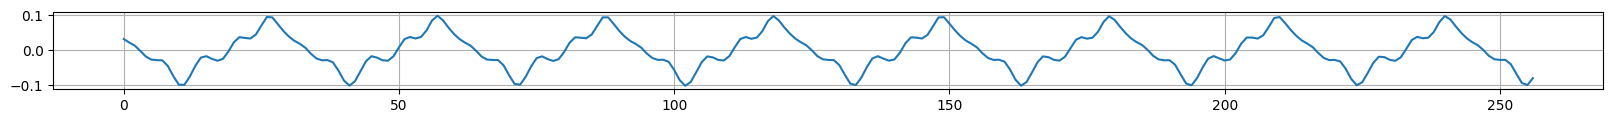

/tmp/ipykernel_470696/3278478625.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return mu_law_encode(np.array(samp))/255.


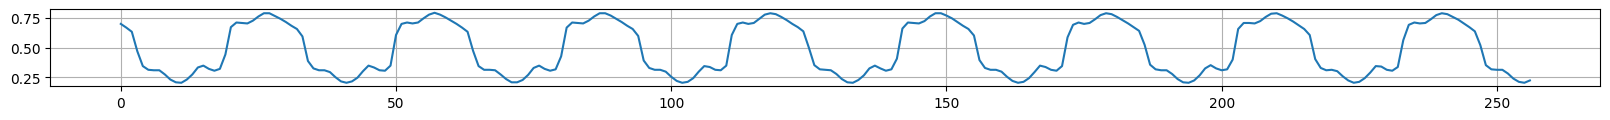

Do it! 2025-08-06 11:47:57
bat num 0 at time 2025-08-06 11:47:57
x_audio_seq.shape = torch.Size([1, 256, 4])
y_target_seq.shape = torch.Size([1, 256, 1])
bat num 1 at time 2025-08-06 11:47:57
x_audio_seq.shape = torch.Size([1, 256, 4])
y_target_seq.shape = torch.Size([1, 256, 1])
finished at 2025-08-06 11:47:57


In [6]:
# show stuff

print("size of dataset is",len(adataset))
print("no. of batches per epoch is", params['batches_per_epoch'])
print("batchsize id  is", params['batch_size'])

samp = adataset.rand_sample()
print(samp.shape)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

samp = inputcoding(samp)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()


n_batches = 1
print("Do it! {}".format(mydate()))
for bat, (x_audio_seq, y_target_seq) in enumerate(test_loader):
    print("bat num {} at time {}".format(bat, mydate()))
    print(f"x_audio_seq.shape = {x_audio_seq.shape}") 
    print(f"y_target_seq.shape = {y_target_seq.shape}")
    if bat >= n_batches :
        break;
print("finished at {}".format(mydate()))

# print(f"x_audio_seq[0,:,0] seq is {x_audio_seq[0,:,0]}")
# print(f"x_audio_seq[0,:,1] seq is {x_audio_seq[0,:,1]}")
# print(f"x_audio_seq[0,:,2] seq is {x_audio_seq[0,:,2]}")
# print(f"x_audio_seq[0,:,3] seq is {x_audio_seq[0,:,3]}")
# print(f"y_target_seq[0,:] seq is {y_target_seq[0,:].squeeze(-1)}")


In [7]:
# ---- Create Output Folders ----
if resume_checkpoint != None:
    out_dir = resume_checkpoint
else:
    run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_dir = os.path.join(params['savemodeldir'], run_timestamp)
    os.makedirs(out_dir, exist_ok=True)

    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(f"{out_dir}/checkpoints", exist_ok=True)
    os.makedirs(f"{out_dir}/tensorboard", exist_ok=True)


# ---- Save Config ----
#machine readable
torch.save({
    "model_config": model_config,
    "data_config": data_config
}, f"{out_dir}/config.pt")

#human readable
with open(f"{out_dir}/config.txt", "w") as f:
    f.write("model_config = " + repr(model_config) + "\\n")
    f.write("data_config = " + repr(data_config) + "\\n")

In [8]:
 # Define the training cycle (100% teacher forcing for now)
 #*************************************
 
 def train(model,epoch):
 
 
     model.train() #put in training mode
     ave_loss_over_steps = 0
 
     debug_seqs=0
 
     for batch_num, (inp, target) in enumerate(train_loader):
 
         # if batch_num==0:
         #     print(f"train() - inp[:,:,0] - Min: {torch.min(inp[:,:,0])}, Max: {torch.max(inp[:,:,0])}, Average: {torch.mean(inp[:,:,0])}")
 
         debug_seqs=debug_seqs+len(inp) # summing the batch length for each batch_num
 
         inp, target = inp.to(device), target.to(device)
         # Forward + Backward + Optimize
         hidden = model.init_hidden(params['batch_size'])
         optimizer.zero_grad()
         loss = 0
 
         #print(f" inp[0,127,0] (B,T,p) is {inp[0,127,0]}")
 
         # iterate through the SEQUENCE
         for i in range(params['seqLen']):
             outputs, hidden = model(inp[:,i,:],hidden,params['batch_size'])  #input dim: (batch, seq, feature)
             loss += criterion(outputs, torch.squeeze(target[:,i],1))
             #print(f"timestep {i} target is {torch.squeeze(target[:,i],1)}")
 
         loss.backward()
         optimizer.step()
 
         ave_loss_per_sample = loss.item()/params['seqLen']   #over each minibatch
         ave_loss_over_steps += ave_loss_per_sample
 
         if (batch_num+1) % log_interval == 0:
             print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], batch_num [{}/{}] Loss: {:.4f}'.format(
                 datetime.now(), epoch+1, params['num_epochs'], batch_num+1, params['batches_per_epoch'], ave_loss_over_steps/log_interval))
 
             list_of_losses.append(ave_loss_over_steps/log_interval)
             writer.add_scalar("Loss/train", ave_loss_per_sample, epoch)
             ave_loss_over_steps = 0
 
 
         if (batch_num+1) % visualize_interval == 0:
             result = generate(model,max_length)
             plt.figure(figsize=(20,1))
             plt.plot(np.arange(len(result)), result) #just print one example from the batch
             plt.show()
             model.train() #put model back to training mode
 
 
         if batch_num>=(params['batches_per_epoch']-1):
             break
 
     print(f"Finished epoch number {epoch} with a total of {debug_seqs} debug_seqs")
     
     if (epoch + 1) % params['savemodel_interval'] == 0:
         torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, checkpoint_path)
         print(f"Saved checkpoint at epoch {epoch+1}")
 
 
 # generate
 #*************************************
 def generate(model,max_length,primer=None,paramvect=None, returnHiddenSequence=False):
     """Generate a signal using the provided model.
     @param max_length of the synthesized signal
     @param primer a torch.tensor of shape (batch=1, primer_signal=primer_length, num_inputs=1+num_cond_parameters)
     @paramvect conditioning parameters  (a function of i, sample number)
     """ 
     if returnHiddenSequence :
         hs=[]
 
     model.eval()
     with torch.no_grad():
 
         for p_inp, target in test_loader:
 
             print(f"generate() - p_inp_inp[:,:,0] - Min: {torch.min(p_inp[:,:,0])}, Max: {torch.max(p_inp[:,:,0])}, Average: {torch.mean(p_inp[:,:,0])}")
 
             if primer is not None:
                 # must clone else primer is changed outside this function
                 p_inp.data=primer.clone()
             print(f"p_inp = {p_inp}")
             seq = np.copy(p_inp[0,:,0])  #extract the original sample
 
             seq_mu = inputcoding(seq)  #mu-law
 
             p_inp[0,:,0] = torch.from_numpy(seq_mu).float() #now we have both the original and mu-lawed samples
             break
         generated = seq # before mu-law audio encoding
 
         p_inp = p_inp.to(device)
         #print("p_inp",p_inp)
 
         hidden = model.init_hidden()
         if returnHiddenSequence :
             hs.append(torch.squeeze(hidden).cpu().numpy())
 
         print(f"---AND the p_inp we will use to build hidden is {p_inp[0,0:10,:]}")
         for j in range(params['seqLen']-1):  #build up hidden state
             _, hidden = model(p_inp[:,j,:],hidden)
         inp = p_inp[:,-1,:]  #feed the last value as the initial value of the actual generation
 
         #print("last inp from primer",inp)
 
         for i in range(max_length):
             outputs, hidden = model(inp,hidden)
 
             outputs = nn.functional.log_softmax(outputs,dim=1)
             topv, topi = outputs.detach().topk(1)  #choose the strongest activation
             #print(topv,topv.shape)
             predicted_sample = index2float(topi)
 
             generated = np.append(generated,predicted_sample)
 
             inp[:,0] = torch.from_numpy(inputcoding([predicted_sample])).type(torch.cuda.FloatTensor)
             #print("input",inp)
             #print("shape",inp.shape)
             if paramvect is not None:
                 inp[:,1:] = torch.tensor(paramvect(i))
                 #print("input2",inp)
 
             if returnHiddenSequence :
                 hs.append(torch.squeeze(hidden).cpu().numpy())
 
         if returnHiddenSequence :
             return generated, hs
         else :
             return generated


<a href="#dataparams">Go To Data Params</a>

In [9]:

rnn = model.gru_audio_model.RNN(model_config).to(device)
    
optimizer = torch.optim.Adam(rnn.parameters(), lr=params['lr'])
criterion = nn.CrossEntropyLoss()

start_epoch=0
checkpoint_path = os.path.join(f"{out_dir}/checkpoints", "last_checkpoint.pt")
if resume_checkpoint:
    assert os.path.exists(checkpoint_path), f"File {checkpoint_path} does not exist"
    checkpoint = torch.load(checkpoint_path)
    rnn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resumed from checkpoint at epoch {start_epoch}")

writer = SummaryWriter(log_dir=f"{out_dir}/tensorboard")

In [10]:
num_trainable_params = sum(p.numel() for p in rnn.parameters() if p.requires_grad)
print(f"Trainable parameters: {num_trainable_params}")

Trainable parameters: 69232


2025-08-06 11:47:57 Starting training...
2025-08-06 11:48:06 Epoch [1/10], batch_num [50/100] Loss: 5.0497
generate() - p_inp_inp[:,:,0] - Min: -0.07951050251722336, Max: 0.05634765699505806, Average: -0.0009203195804730058
p_inp = tensor([[[ 0.0500,  0.0000,  0.2000,  0.5000],
         [ 0.0314,  0.0000,  0.2000,  0.5000],
         [ 0.0070,  0.0000,  0.2000,  0.5000],
         ...,
         [-0.0184,  0.0000,  0.2000,  0.5000],
         [-0.0414,  0.0000,  0.2000,  0.5000],
         [-0.0638,  0.0000,  0.2000,  0.5000]]])
---AND the p_inp we will use to build hidden is tensor([[0.7373, 0.0000, 0.2000, 0.5000],
        [0.6980, 0.0000, 0.2000, 0.5000],
        [0.5922, 0.0000, 0.2000, 0.5000],
        [0.3608, 0.0000, 0.2000, 0.5000],
        [0.3137, 0.0000, 0.2000, 0.5000],
        [0.2941, 0.0000, 0.2000, 0.5000],
        [0.2824, 0.0000, 0.2000, 0.5000],
        [0.2902, 0.0000, 0.2000, 0.5000],
        [0.3294, 0.0000, 0.2000, 0.5000],
        [0.4039, 0.0000, 0.2000, 0.5000]], d

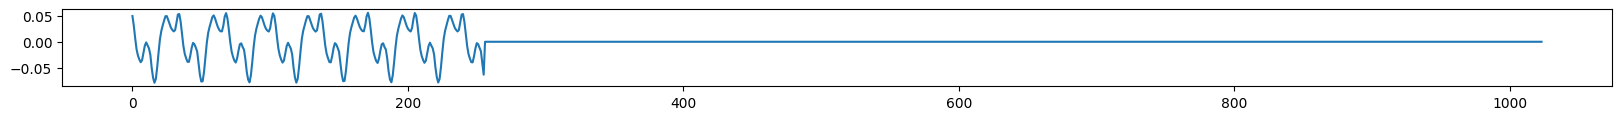

2025-08-06 11:48:15 Epoch [1/10], batch_num [100/100] Loss: 4.6048
generate() - p_inp_inp[:,:,0] - Min: -0.0930938720703125, Max: 0.197509765625, Average: 0.0003203153610229492
p_inp = tensor([[[0.0721, 1.0000, 0.5000, 0.4167],
         [0.1066, 1.0000, 0.5000, 0.4167],
         [0.1207, 1.0000, 0.5000, 0.4167],
         ...,
         [0.0158, 1.0000, 0.5000, 0.4167],
         [0.0469, 1.0000, 0.5000, 0.4167],
         [0.0734, 1.0000, 0.5000, 0.4167]]])
---AND the p_inp we will use to build hidden is tensor([[0.7686, 1.0000, 0.5000, 0.4167],
        [0.8000, 1.0000, 0.5000, 0.4167],
        [0.8118, 1.0000, 0.5000, 0.4167],
        [0.8235, 1.0000, 0.5000, 0.4167],
        [0.8549, 1.0000, 0.5000, 0.4167],
        [0.7961, 1.0000, 0.5000, 0.4167],
        [0.2980, 1.0000, 0.5000, 0.4167],
        [0.2196, 1.0000, 0.5000, 0.4167],
        [0.2157, 1.0000, 0.5000, 0.4167],
        [0.2627, 1.0000, 0.5000, 0.4167]], device='cuda:0')


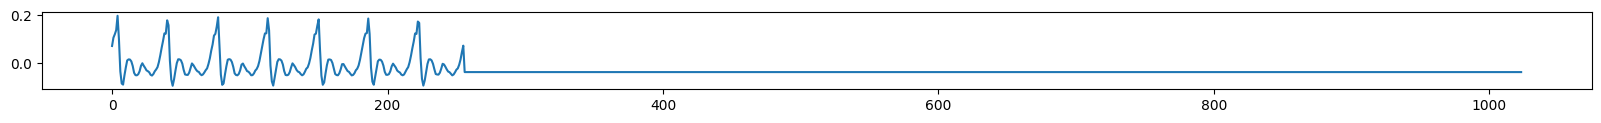

Finished epoch number 0 with a total of 25600 debug_seqs
2025-08-06 11:48:24 Epoch [2/10], batch_num [50/100] Loss: 4.3895
generate() - p_inp_inp[:,:,0] - Min: 0.0, Max: 0.0, Average: 0.0
p_inp = tensor([[[-0., 0., 0., 1.],
         [-0., 0., 0., 1.],
         [-0., 0., 0., 1.],
         ...,
         [-0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]]])
---AND the p_inp we will use to build hidden is tensor([[0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000]], device='cuda:0')


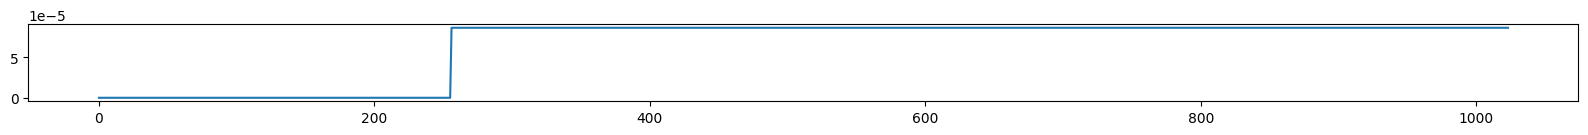

2025-08-06 11:48:33 Epoch [2/10], batch_num [100/100] Loss: 4.0115
generate() - p_inp_inp[:,:,0] - Min: -0.15694580972194672, Max: 0.10944824665784836, Average: -0.00048537299153394997
p_inp = tensor([[[-0.0978,  0.0000,  0.4000,  0.4167],
         [-0.0458,  0.0000,  0.4000,  0.4167],
         [ 0.0078,  0.0000,  0.4000,  0.4167],
         ...,
         [-0.1545,  0.0000,  0.4000,  0.4167],
         [-0.1247,  0.0000,  0.4000,  0.4167],
         [-0.0773,  0.0000,  0.4000,  0.4167]]])
---AND the p_inp we will use to build hidden is tensor([[0.2078, 0.0000, 0.4000, 0.4167],
        [0.2706, 0.0000, 0.4000, 0.4167],
        [0.6000, 0.0000, 0.4000, 0.4167],
        [0.7294, 0.0000, 0.4000, 0.4167],
        [0.7647, 0.0000, 0.4000, 0.4167],
        [0.7843, 0.0000, 0.4000, 0.4167],
        [0.7961, 0.0000, 0.4000, 0.4167],
        [0.8000, 0.0000, 0.4000, 0.4167],
        [0.7922, 0.0000, 0.4000, 0.4167],
        [0.7725, 0.0000, 0.4000, 0.4167]], device='cuda:0')


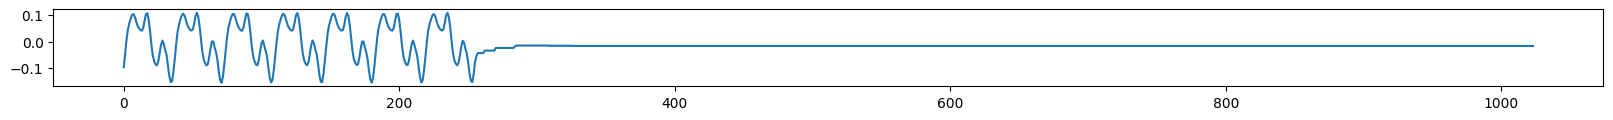

Finished epoch number 1 with a total of 25600 debug_seqs
2025-08-06 11:48:42 Epoch [3/10], batch_num [50/100] Loss: 3.9686
generate() - p_inp_inp[:,:,0] - Min: -0.12337646633386612, Max: 0.13887634873390198, Average: -3.4869066439568996e-05
p_inp = tensor([[[ 0.0270,  0.0000,  0.3000,  0.1667],
         [ 0.0443,  0.0000,  0.3000,  0.1667],
         [ 0.0702,  0.0000,  0.3000,  0.1667],
         ...,
         [-0.1152,  0.0000,  0.3000,  0.1667],
         [-0.0957,  0.0000,  0.3000,  0.1667],
         [-0.0601,  0.0000,  0.3000,  0.1667]]])
---AND the p_inp we will use to build hidden is tensor([[0.6863, 0.0000, 0.3000, 0.1667],
        [0.7255, 0.0000, 0.3000, 0.1667],
        [0.7647, 0.0000, 0.3000, 0.1667],
        [0.7804, 0.0000, 0.3000, 0.1667],
        [0.7647, 0.0000, 0.3000, 0.1667],
        [0.7020, 0.0000, 0.3000, 0.1667],
        [0.5608, 0.0000, 0.3000, 0.1667],
        [0.5216, 0.0000, 0.3000, 0.1667],
        [0.6667, 0.0000, 0.3000, 0.1667],
        [0.7255, 0.0000, 0.

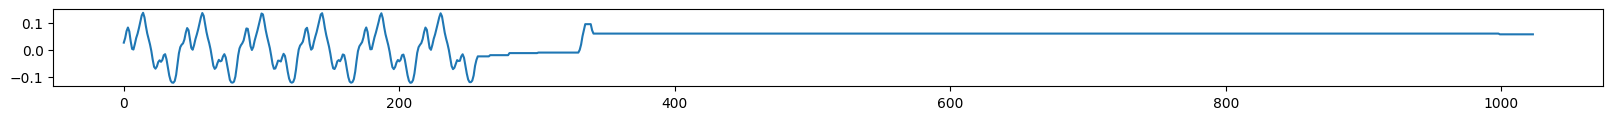

2025-08-06 11:48:51 Epoch [3/10], batch_num [100/100] Loss: 3.7714
generate() - p_inp_inp[:,:,0] - Min: -0.27897951006889343, Max: 0.20498047769069672, Average: -0.006887626834213734
p_inp = tensor([[[-0.1724,  0.0000,  0.8000,  0.5000],
         [-0.1639,  0.0000,  0.8000,  0.5000],
         [-0.1172,  0.0000,  0.8000,  0.5000],
         ...,
         [-0.0420,  0.0000,  0.8000,  0.5000],
         [ 0.0677,  0.0000,  0.8000,  0.5000],
         [ 0.1342,  0.0000,  0.8000,  0.5000]]])
---AND the p_inp we will use to build hidden is tensor([[0.1569, 0.0000, 0.8000, 0.5000],
        [0.1608, 0.0000, 0.8000, 0.5000],
        [0.1922, 0.0000, 0.8000, 0.5000],
        [0.2510, 0.0000, 0.8000, 0.5000],
        [0.3216, 0.0000, 0.8000, 0.5000],
        [0.2588, 0.0000, 0.8000, 0.5000],
        [0.2118, 0.0000, 0.8000, 0.5000],
        [0.1961, 0.0000, 0.8000, 0.5000],
        [0.1490, 0.0000, 0.8000, 0.5000],
        [0.1216, 0.0000, 0.8000, 0.5000]], device='cuda:0')


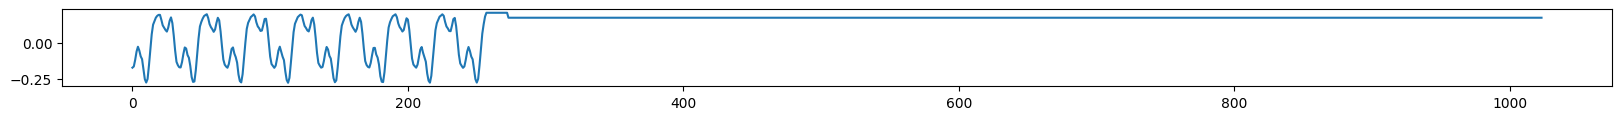

Finished epoch number 2 with a total of 25600 debug_seqs
2025-08-06 11:49:01 Epoch [4/10], batch_num [50/100] Loss: 3.6774
generate() - p_inp_inp[:,:,0] - Min: 0.0, Max: 0.0, Average: 0.0
p_inp = tensor([[[0.0000, 1.0000, 0.0000, 0.1667],
         [0.0000, 1.0000, 0.0000, 0.1667],
         [0.0000, 1.0000, 0.0000, 0.1667],
         ...,
         [-0.0000, 1.0000, 0.0000, 0.1667],
         [0.0000, 1.0000, 0.0000, 0.1667],
         [0.0000, 1.0000, 0.0000, 0.1667]]])
---AND the p_inp we will use to build hidden is tensor([[0.5020, 1.0000, 0.0000, 0.1667],
        [0.5020, 1.0000, 0.0000, 0.1667],
        [0.5020, 1.0000, 0.0000, 0.1667],
        [0.5020, 1.0000, 0.0000, 0.1667],
        [0.5020, 1.0000, 0.0000, 0.1667],
        [0.5020, 1.0000, 0.0000, 0.1667],
        [0.5020, 1.0000, 0.0000, 0.1667],
        [0.5020, 1.0000, 0.0000, 0.1667],
        [0.5020, 1.0000, 0.0000, 0.1667],
        [0.5020, 1.0000, 0.0000, 0.1667]], device='cuda:0')


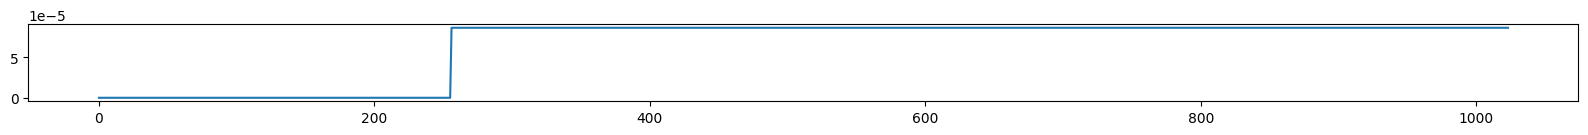

2025-08-06 11:49:09 Epoch [4/10], batch_num [100/100] Loss: 3.5447
generate() - p_inp_inp[:,:,0] - Min: -0.08380737900733948, Max: 0.090087890625, Average: 0.002052533905953169
p_inp = tensor([[[ 0.0771,  0.0000,  0.3000,  0.0833],
         [ 0.0817,  0.0000,  0.3000,  0.0833],
         [ 0.0666,  0.0000,  0.3000,  0.0833],
         ...,
         [-0.0672,  0.0000,  0.3000,  0.0833],
         [-0.0575,  0.0000,  0.3000,  0.0833],
         [-0.0547,  0.0000,  0.3000,  0.0833]]])
---AND the p_inp we will use to build hidden is tensor([[0.7725, 0.0000, 0.3000, 0.0833],
        [0.7765, 0.0000, 0.3000, 0.0833],
        [0.7608, 0.0000, 0.3000, 0.0833],
        [0.7216, 0.0000, 0.3000, 0.0833],
        [0.6863, 0.0000, 0.3000, 0.0833],
        [0.7059, 0.0000, 0.3000, 0.0833],
        [0.7412, 0.0000, 0.3000, 0.0833],
        [0.7569, 0.0000, 0.3000, 0.0833],
        [0.7608, 0.0000, 0.3000, 0.0833],
        [0.7647, 0.0000, 0.3000, 0.0833]], device='cuda:0')


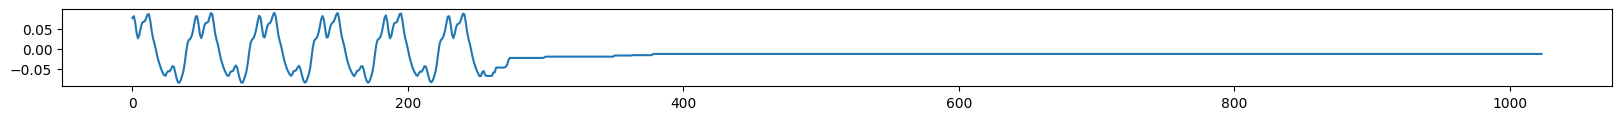

Finished epoch number 3 with a total of 25600 debug_seqs
2025-08-06 11:49:19 Epoch [5/10], batch_num [50/100] Loss: 3.4562
generate() - p_inp_inp[:,:,0] - Min: -0.08558350056409836, Max: 0.14052429795265198, Average: 0.0009016156545840204
p_inp = tensor([[[-0.0281,  1.0000,  0.3000,  0.1667],
         [-0.0166,  1.0000,  0.3000,  0.1667],
         [-0.0068,  1.0000,  0.3000,  0.1667],
         ...,
         [ 0.1199,  1.0000,  0.3000,  0.1667],
         [ 0.0157,  1.0000,  0.3000,  0.1667],
         [-0.0562,  1.0000,  0.3000,  0.1667]]])
---AND the p_inp we will use to build hidden is tensor([[0.3098, 1.0000, 0.3000, 0.1667],
        [0.3490, 1.0000, 0.3000, 0.1667],
        [0.4078, 1.0000, 0.3000, 0.1667],
        [0.4157, 1.0000, 0.3000, 0.1667],
        [0.3804, 1.0000, 0.3000, 0.1667],
        [0.3765, 1.0000, 0.3000, 0.1667],
        [0.4471, 1.0000, 0.3000, 0.1667],
        [0.5098, 1.0000, 0.3000, 0.1667],
        [0.4510, 1.0000, 0.3000, 0.1667],
        [0.3725, 1.0000, 0.30

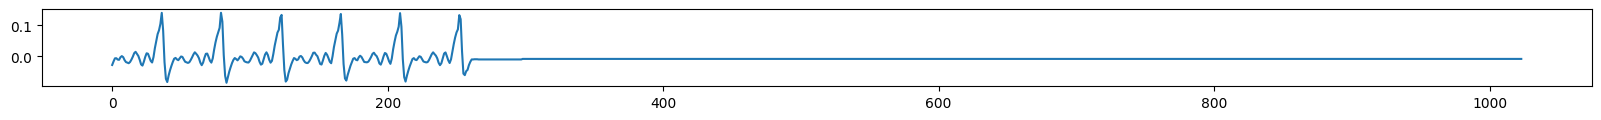

2025-08-06 11:49:28 Epoch [5/10], batch_num [100/100] Loss: 3.4040
generate() - p_inp_inp[:,:,0] - Min: -0.02970275841653347, Max: 0.037506103515625, Average: -0.00035564907011575997
p_inp = tensor([[[0.0373, 0.0000, 0.1000, 0.7500],
         [0.0341, 0.0000, 0.1000, 0.7500],
         [0.0243, 0.0000, 0.1000, 0.7500],
         ...,
         [0.0059, 0.0000, 0.1000, 0.7500],
         [0.0105, 0.0000, 0.1000, 0.7500],
         [0.0164, 0.0000, 0.1000, 0.7500]]])
---AND the p_inp we will use to build hidden is tensor([[0.7137, 0.0000, 0.1000, 0.7500],
        [0.7059, 0.0000, 0.1000, 0.7500],
        [0.6784, 0.0000, 0.1000, 0.7500],
        [0.6353, 0.0000, 0.1000, 0.7500],
        [0.5922, 0.0000, 0.1000, 0.7500],
        [0.5529, 0.0000, 0.1000, 0.7500],
        [0.4627, 0.0000, 0.1000, 0.7500],
        [0.3922, 0.0000, 0.1000, 0.7500],
        [0.3608, 0.0000, 0.1000, 0.7500],
        [0.3529, 0.0000, 0.1000, 0.7500]], device='cuda:0')


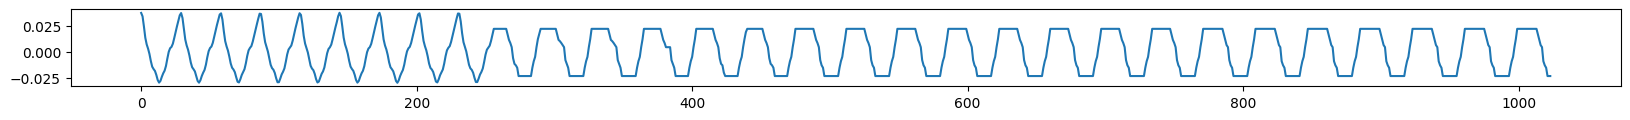

Finished epoch number 4 with a total of 25600 debug_seqs
2025-08-06 11:49:37 Epoch [6/10], batch_num [50/100] Loss: 3.3336
generate() - p_inp_inp[:,:,0] - Min: -0.03137512132525444, Max: 0.03232116624712944, Average: -2.3031301680020988e-05
p_inp = tensor([[[ 4.0344e-03,  0.0000e+00,  1.0000e-01,  9.1667e-01],
         [-5.8594e-04,  0.0000e+00,  1.0000e-01,  9.1667e-01],
         [-7.5592e-03,  0.0000e+00,  1.0000e-01,  9.1667e-01],
         ...,
         [ 2.6157e-02,  0.0000e+00,  1.0000e-01,  9.1667e-01],
         [ 1.9968e-02,  0.0000e+00,  1.0000e-01,  9.1667e-01],
         [ 1.3382e-02,  0.0000e+00,  1.0000e-01,  9.1667e-01]]])
---AND the p_inp we will use to build hidden is tensor([[0.5647, 0.0000, 0.1000, 0.9167],
        [0.4863, 0.0000, 0.1000, 0.9167],
        [0.4039, 0.0000, 0.1000, 0.9167],
        [0.3569, 0.0000, 0.1000, 0.9167],
        [0.3333, 0.0000, 0.1000, 0.9167],
        [0.3255, 0.0000, 0.1000, 0.9167],
        [0.3216, 0.0000, 0.1000, 0.9167],
        [0.3137

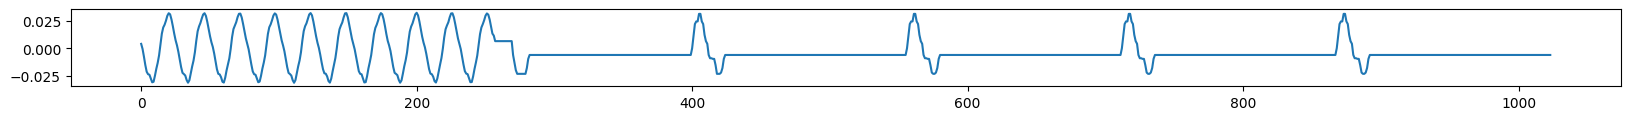

2025-08-06 11:49:46 Epoch [6/10], batch_num [100/100] Loss: 3.2857
generate() - p_inp_inp[:,:,0] - Min: -0.07944946736097336, Max: 0.18093568086624146, Average: -0.0010777476709336042
p_inp = tensor([[[-4.1052e-02,  1.0000e+00,  3.0000e-01,  5.0000e-01],
         [-7.5998e-02,  1.0000e+00,  3.0000e-01,  5.0000e-01],
         [-7.0670e-02,  1.0000e+00,  3.0000e-01,  5.0000e-01],
         ...,
         [-1.7194e-02,  1.0000e+00,  3.0000e-01,  5.0000e-01],
         [-5.0537e-03,  1.0000e+00,  3.0000e-01,  5.0000e-01],
         [ 8.7891e-04,  1.0000e+00,  3.0000e-01,  5.0000e-01]]])
---AND the p_inp we will use to build hidden is tensor([[0.2784, 1.0000, 0.3000, 0.5000],
        [0.2275, 1.0000, 0.3000, 0.5000],
        [0.2353, 1.0000, 0.3000, 0.5000],
        [0.2627, 1.0000, 0.3000, 0.5000],
        [0.3137, 1.0000, 0.3000, 0.5000],
        [0.4549, 1.0000, 0.3000, 0.5000],
        [0.5922, 1.0000, 0.3000, 0.5000],
        [0.6078, 1.0000, 0.3000, 0.5000],
        [0.6039, 1.0000, 0.300

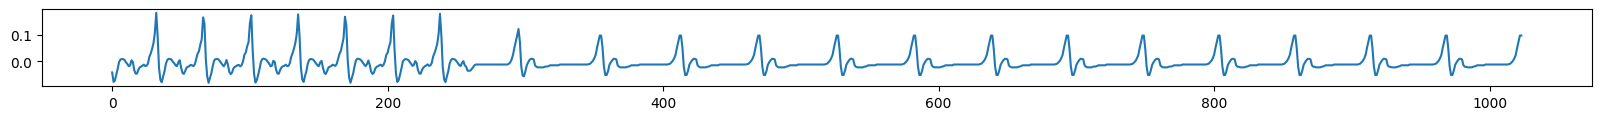

Finished epoch number 5 with a total of 25600 debug_seqs
2025-08-06 11:49:56 Epoch [7/10], batch_num [50/100] Loss: 3.2312
generate() - p_inp_inp[:,:,0] - Min: -0.14111328125, Max: 0.261444091796875, Average: -0.0005791783332824707
p_inp = tensor([[[ 0.1932,  1.0000,  0.5000,  0.0000],
         [ 0.2516,  1.0000,  0.5000,  0.0000],
         [ 0.0916,  1.0000,  0.5000,  0.0000],
         ...,
         [-0.0354,  1.0000,  0.5000,  0.0000],
         [-0.0316,  1.0000,  0.5000,  0.0000],
         [-0.0257,  1.0000,  0.5000,  0.0000]]])
---AND the p_inp we will use to build hidden is tensor([[0.8549, 1.0000, 0.5000, 0.0000],
        [0.8784, 1.0000, 0.5000, 0.0000],
        [0.7882, 1.0000, 0.5000, 0.0000],
        [0.2196, 1.0000, 0.5000, 0.0000],
        [0.1765, 1.0000, 0.5000, 0.0000],
        [0.2000, 1.0000, 0.5000, 0.0000],
        [0.2431, 1.0000, 0.5000, 0.0000],
        [0.2314, 1.0000, 0.5000, 0.0000],
        [0.2353, 1.0000, 0.5000, 0.0000],
        [0.2549, 1.0000, 0.5000, 0.0

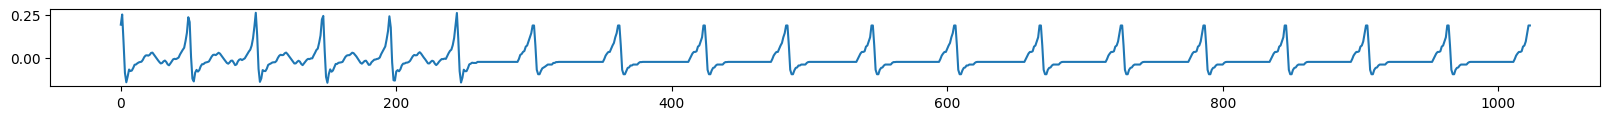

2025-08-06 11:50:04 Epoch [7/10], batch_num [100/100] Loss: 3.1828
generate() - p_inp_inp[:,:,0] - Min: -0.02686767652630806, Max: 0.02294006384909153, Average: -9.473553654970601e-05
p_inp = tensor([[[ 0.0217,  0.0000,  0.1000,  0.9167],
         [ 0.0225,  0.0000,  0.1000,  0.9167],
         [ 0.0229,  0.0000,  0.1000,  0.9167],
         ...,
         [-0.0032,  0.0000,  0.1000,  0.9167],
         [ 0.0050,  0.0000,  0.1000,  0.9167],
         [ 0.0132,  0.0000,  0.1000,  0.9167]]])
---AND the p_inp we will use to build hidden is tensor([[0.6706, 0.0000, 0.1000, 0.9167],
        [0.6706, 0.0000, 0.1000, 0.9167],
        [0.6745, 0.0000, 0.1000, 0.9167],
        [0.6745, 0.0000, 0.1000, 0.9167],
        [0.6706, 0.0000, 0.1000, 0.9167],
        [0.6706, 0.0000, 0.1000, 0.9167],
        [0.6549, 0.0000, 0.1000, 0.9167],
        [0.6196, 0.0000, 0.1000, 0.9167],
        [0.5608, 0.0000, 0.1000, 0.9167],
        [0.4745, 0.0000, 0.1000, 0.9167]], device='cuda:0')


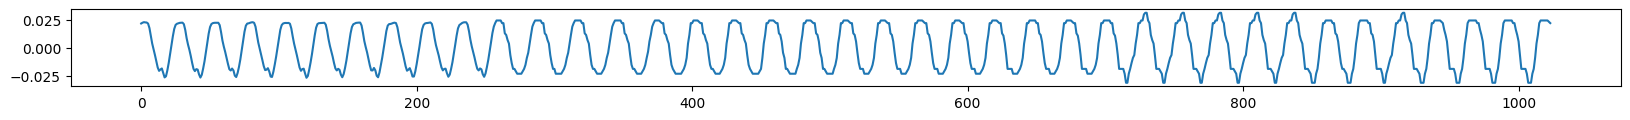

Finished epoch number 6 with a total of 25600 debug_seqs
2025-08-06 11:50:14 Epoch [8/10], batch_num [50/100] Loss: 3.1525
generate() - p_inp_inp[:,:,0] - Min: -0.05090942606329918, Max: 0.0765380859375, Average: 0.00031492713605985045
p_inp = tensor([[[-0.0298,  1.0000,  0.2000,  0.5833],
         [-0.0232,  1.0000,  0.2000,  0.5833],
         [-0.0160,  1.0000,  0.2000,  0.5833],
         ...,
         [-0.0019,  1.0000,  0.2000,  0.5833],
         [-0.0141,  1.0000,  0.2000,  0.5833],
         [-0.0206,  1.0000,  0.2000,  0.5833]]])
---AND the p_inp we will use to build hidden is tensor([[0.3059, 1.0000, 0.2000, 0.5833],
        [0.3255, 1.0000, 0.2000, 0.5833],
        [0.3529, 1.0000, 0.2000, 0.5833],
        [0.3804, 1.0000, 0.2000, 0.5833],
        [0.3961, 1.0000, 0.2000, 0.5833],
        [0.5412, 1.0000, 0.2000, 0.5833],
        [0.6549, 1.0000, 0.2000, 0.5833],
        [0.7176, 1.0000, 0.2000, 0.5833],
        [0.7255, 1.0000, 0.2000, 0.5833],
        [0.7176, 1.0000, 0.2000,

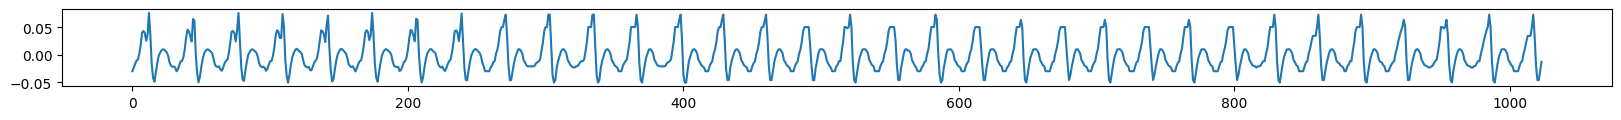

2025-08-06 11:50:23 Epoch [8/10], batch_num [100/100] Loss: 3.1173
generate() - p_inp_inp[:,:,0] - Min: -0.1539306640625, Max: 0.4391113221645355, Average: 0.00035753275733441114
p_inp = tensor([[[-0.0706,  1.0000,  0.8000,  0.9167],
         [-0.0310,  1.0000,  0.8000,  0.9167],
         [ 0.0057,  1.0000,  0.8000,  0.9167],
         ...,
         [-0.0465,  1.0000,  0.8000,  0.9167],
         [-0.1387,  1.0000,  0.8000,  0.9167],
         [-0.1458,  1.0000,  0.8000,  0.9167]]])
---AND the p_inp we will use to build hidden is tensor([[0.2353, 1.0000, 0.8000, 0.9167],
        [0.3020, 1.0000, 0.8000, 0.9167],
        [0.5804, 1.0000, 0.8000, 0.9167],
        [0.6941, 1.0000, 0.8000, 0.9167],
        [0.6706, 1.0000, 0.8000, 0.9167],
        [0.6431, 1.0000, 0.8000, 0.9167],
        [0.3961, 1.0000, 0.8000, 0.9167],
        [0.3176, 1.0000, 0.8000, 0.9167],
        [0.2902, 1.0000, 0.8000, 0.9167],
        [0.2706, 1.0000, 0.8000, 0.9167]], device='cuda:0')


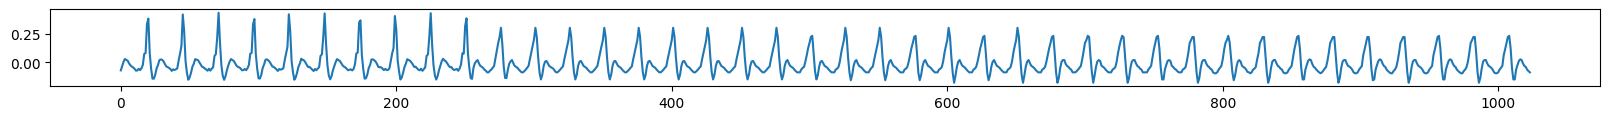

Finished epoch number 7 with a total of 25600 debug_seqs
2025-08-06 11:50:32 Epoch [9/10], batch_num [50/100] Loss: 3.0700
generate() - p_inp_inp[:,:,0] - Min: -0.06024780496954918, Max: 0.13367919623851776, Average: -0.000556778977625072
p_inp = tensor([[[ 0.0086,  1.0000,  0.2000,  0.5000],
         [ 0.0119,  1.0000,  0.2000,  0.5000],
         [ 0.0059,  1.0000,  0.2000,  0.5000],
         ...,
         [-0.0356,  1.0000,  0.2000,  0.5000],
         [-0.0222,  1.0000,  0.2000,  0.5000],
         [-0.0111,  1.0000,  0.2000,  0.5000]]])
---AND the p_inp we will use to build hidden is tensor([[0.6039, 1.0000, 0.2000, 0.5000],
        [0.6275, 1.0000, 0.2000, 0.5000],
        [0.5843, 1.0000, 0.2000, 0.5000],
        [0.5373, 1.0000, 0.2000, 0.5000],
        [0.4392, 1.0000, 0.2000, 0.5000],
        [0.4235, 1.0000, 0.2000, 0.5000],
        [0.3804, 1.0000, 0.2000, 0.5000],
        [0.3922, 1.0000, 0.2000, 0.5000],
        [0.5608, 1.0000, 0.2000, 0.5000],
        [0.6118, 1.0000, 0.20

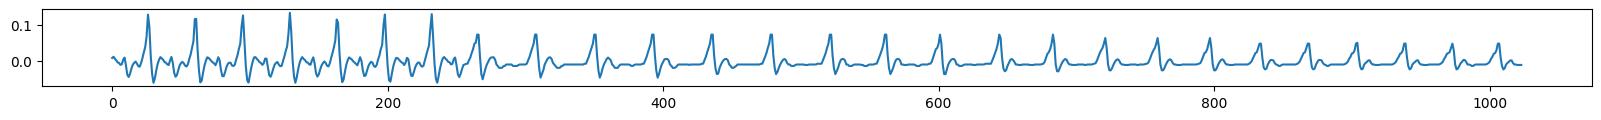

2025-08-06 11:50:41 Epoch [9/10], batch_num [100/100] Loss: 3.0286
generate() - p_inp_inp[:,:,0] - Min: -0.01980285719037056, Max: 0.04841308668255806, Average: -0.00010223387653240934
p_inp = tensor([[[-3.8330e-03,  1.0000e+00,  1.0000e-01,  7.5000e-01],
         [-2.8595e-03,  1.0000e+00,  1.0000e-01,  7.5000e-01],
         [-9.1553e-04,  1.0000e+00,  1.0000e-01,  7.5000e-01],
         ...,
         [-5.5664e-03,  1.0000e+00,  1.0000e-01,  7.5000e-01],
         [-1.3062e-03,  1.0000e+00,  1.0000e-01,  7.5000e-01],
         [ 5.4932e-03,  1.0000e+00,  1.0000e-01,  7.5000e-01]]])
---AND the p_inp we will use to build hidden is tensor([[0.4392, 1.0000, 0.1000, 0.7500],
        [0.4510, 1.0000, 0.1000, 0.7500],
        [0.4824, 1.0000, 0.1000, 0.7500],
        [0.5176, 1.0000, 0.1000, 0.7500],
        [0.5176, 1.0000, 0.1000, 0.7500],
        [0.4902, 1.0000, 0.1000, 0.7500],
        [0.4784, 1.0000, 0.1000, 0.7500],
        [0.4392, 1.0000, 0.1000, 0.7500],
        [0.3804, 1.0000, 0.10

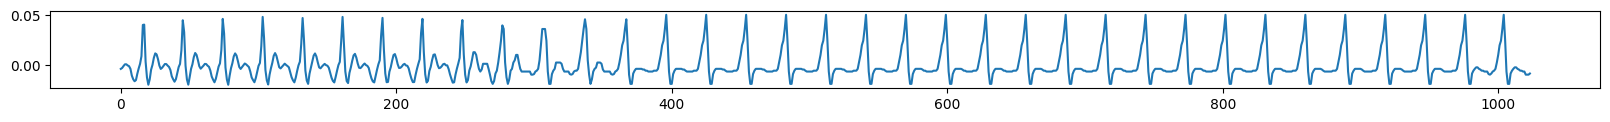

Finished epoch number 8 with a total of 25600 debug_seqs
2025-08-06 11:50:51 Epoch [10/10], batch_num [50/100] Loss: 3.0259
generate() - p_inp_inp[:,:,0] - Min: -0.24943847954273224, Max: 0.23671875894069672, Average: -0.00521039916202426
p_inp = tensor([[[-0.1167,  0.0000,  0.8000,  1.0000],
         [-0.1452,  0.0000,  0.8000,  1.0000],
         [-0.1526,  0.0000,  0.8000,  1.0000],
         ...,
         [ 0.0392,  0.0000,  0.8000,  1.0000],
         [ 0.1145,  0.0000,  0.8000,  1.0000],
         [ 0.1482,  0.0000,  0.8000,  1.0000]]])
---AND the p_inp we will use to build hidden is tensor([[0.1922, 0.0000, 0.8000, 1.0000],
        [0.1725, 0.0000, 0.8000, 1.0000],
        [0.1686, 0.0000, 0.8000, 1.0000],
        [0.1608, 0.0000, 0.8000, 1.0000],
        [0.1373, 0.0000, 0.8000, 1.0000],
        [0.1255, 0.0000, 0.8000, 1.0000],
        [0.1294, 0.0000, 0.8000, 1.0000],
        [0.1569, 0.0000, 0.8000, 1.0000],
        [0.1922, 0.0000, 0.8000, 1.0000],
        [0.2431, 0.0000, 0.80

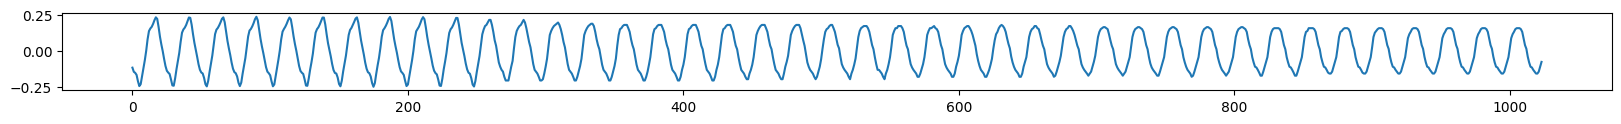

2025-08-06 11:51:00 Epoch [10/10], batch_num [100/100] Loss: 2.9938
generate() - p_inp_inp[:,:,0] - Min: 0.0, Max: 0.0, Average: 0.0
p_inp = tensor([[[-0., 0., 0., 1.],
         [-0., 0., 0., 1.],
         [-0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.]]])
---AND the p_inp we will use to build hidden is tensor([[0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000],
        [0.5020, 0.0000, 0.0000, 1.0000]], device='cuda:0')


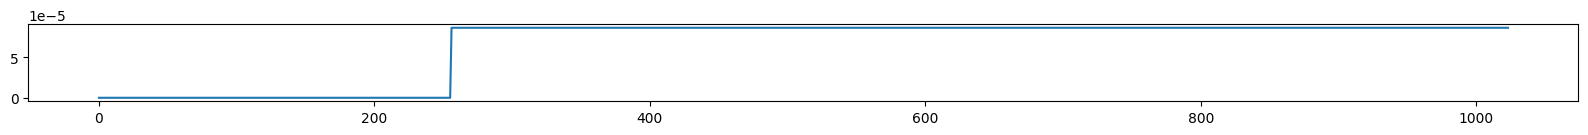

Finished epoch number 9 with a total of 25600 debug_seqs
Saved checkpoint at epoch 10
Training time taken: 0:03:03
Saved checkpoint at epoch 10


In [11]:
# Train!
#*************************************
list_of_losses = []

print('{:%Y-%m-%d %H:%M:%S} Starting training...'.format(datetime.now()))
start_time = time.monotonic()
for epoch in range(start_epoch, start_epoch+params['num_epochs']):
    train(rnn,epoch)
writer.close()
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))


torch.save({
            'epoch': epoch,
            'model_state_dict': rnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, checkpoint_path)
print(f"Saved checkpoint at epoch {epoch+1}")

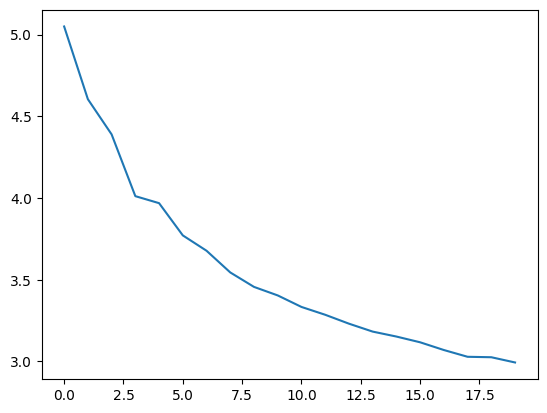

In [12]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)
plt.show()  # This will actually display the plot

In [13]:
foo=[[0.20784315]]
foo[0][0]

0.20784315

In [14]:
list_of_losses

[5.049652481079102,
 4.604756002426147,
 4.38949728012085,
 4.011497640609742,
 3.968595986366272,
 3.771392960548401,
 3.67743501663208,
 3.54466411113739,
 3.456243257522583,
 3.404042811393738,
 3.333617525100708,
 3.2857199239730837,
 3.2312493181228636,
 3.1827706146240233,
 3.1524631929397584,
 3.1172809410095215,
 3.0700322866439818,
 3.028604340553284,
 3.025862522125244,
 2.993797116279602]